In [14]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from bayes_traj.pyro_helper import *

torch.set_default_dtype(torch.double)

# Read toy data and plot

In [15]:
df = pd.read_csv('2d_gaussian_3_visits_std-0.05.csv')
preds = ['intercept', 'age']
targets = ['y1']

Color-code data based on ground-truth trajectory assignment ('traj_gt')

Text(0, 0.5, 'y1')

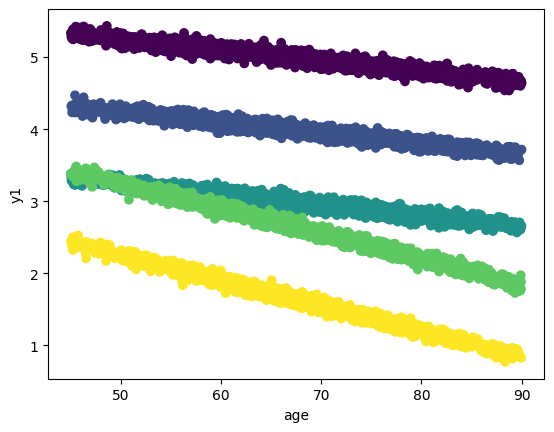

In [16]:
plt.scatter(df['age'], df['y1'], c=df['traj_gt'])
plt.xlabel('age')
plt.ylabel('y1')

# Fit to data

In [26]:
!bayes_traj_main --in_csv 2d_gaussian_3_visits_std-0.05.csv --targets y1 --groupby id --prior 2d_gaussians_3_visits_std-0.05_prior.p --verbose --iters 1 --repeats 1 --use_pyro -k 5 --out_model foo_pyro.pt

Reading prior...
Reading data...
Fitting...
step    0 loss = 307.937
DONE.


# Inspect fit

In [27]:
model = torch.load('foo_pyro.pt')

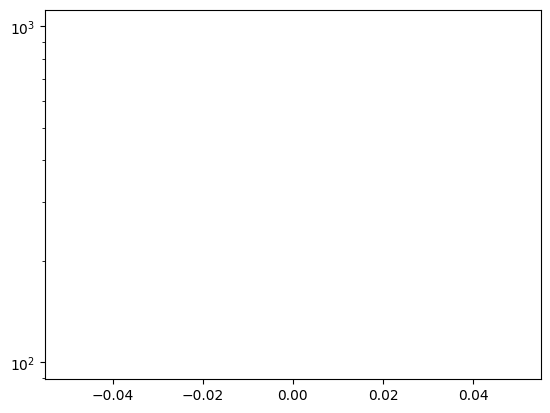

In [28]:
plt.plot(model.losses)
plt.yscale('log')

In [29]:
X_re, X_mask, Y_re, Y_mask = get_restructured_data(df, preds, targets, 'id')
#print(X_re.shape)
#print(Y_re.shape)
#print(Y_mask.shape)

In [30]:
probs = model.classify(X_re, Y_real=Y_re, Y_real_mask=Y_mask)

In [31]:
print(probs)

tensor([[0.2200, 0.2000, 0.1600, 0.1900, 0.2300],
        [0.2300, 0.2600, 0.1800, 0.1600, 0.1700],
        [0.2000, 0.2500, 0.2400, 0.1800, 0.1300],
        ...,
        [0.2200, 0.2000, 0.1700, 0.2200, 0.1900],
        [0.1800, 0.1600, 0.2600, 0.1800, 0.2200],
        [0.1400, 0.1100, 0.2200, 0.2300, 0.3000]])


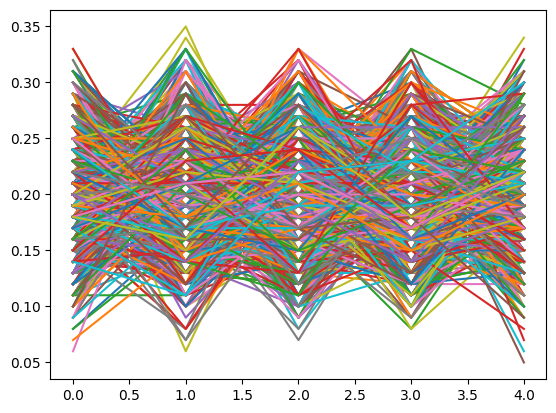

In [32]:
plt.plot(probs.T);

Overlap trajectories with data to inspect fit:

IndexError: too many indices for tensor of dimension 2

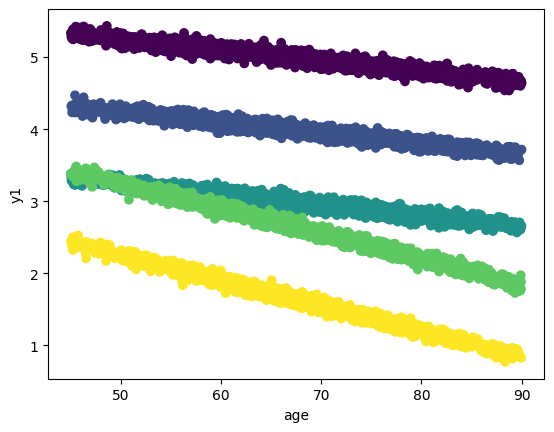

In [39]:
plt.close('all')

plt.scatter(df['age'], df['y1'], c=df['traj_gt'])
plt.xlabel('age')
plt.ylabel('y1')

K = 5
X = torch.ones([100, 2])
X[:, 1] = torch.linspace(45, 90, 100)
for kk in range(K):
    w = model.params['params']['AutoNormal.locs.W_'][kk, 0]
    lambda_ = model.params['params']['AutoNormal.locs.lambda_'][kk]
    stddev = lambda_.rsqrt()
    y1_tmp = np.dot(X.numpy(), w.detach().numpy().T)
    plt.plot(X[:, 1], y1_tmp)
    lb = y1_tmp - 2*stddev
    ub = y1_tmp + 2*stddev
    plt.fill_between(X[:, 1], lb, ub, alpha=0.2)
plt.show()

In [ ]:
q